# Diverging colour map with movable midpoint
Gilles Ferrand<br>
2019-08-26

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
print matplotlib.__version__
%matplotlib inline

2.1.1


test data

In [2]:
x = np.arange(0, 2*np.pi, 0.01)
y = np.arange(0,   np.pi, 0.01)
X,Y = np.meshgrid(x,y)
Z = -np.sin(X)*np.sin(Y)

In [3]:
def show(array, norm, cmap, ticks_delta=0.5):
    plt.figure(figsize=(10,4))
    plt.imshow(array, aspect='equal', interpolation='nearest', norm=norm, cmap=cmap)
    plt.axis('off')
    ticks = matplotlib.ticker.MultipleLocator(ticks_delta)
    #ticks = np.linspace(-1,+1,5) # 5 equi-spaced ticks
    plt.colorbar(ticks=ticks)

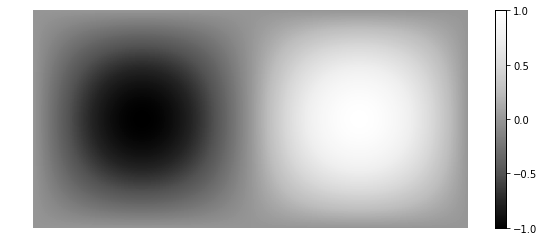

In [4]:
norm = matplotlib.colors.Normalize(vmin=round(Z.min()),vmax=round(Z.max())) # the default normalizer
cmap = matplotlib.cm.Greys_r # the stock greyscale colour map
show(Z, norm, cmap)

Let's say the data has a physical threshold at zero, then it makes sense to display it with a diverging colour map.<br>Let's define a simple custom one.

In [5]:
startcolor = [0,0,1] # blue
midcolor   = [0,0,0] # black
endcolor   = [1,0,0] # red
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('red-black-blue',[startcolor,midcolor,endcolor])
plt.register_cmap(cmap=cmap)

(Note: with this method, the colour interpolation happens in RGB space. For more complicated palettes, the path should rather be defined in a perceptual colour space, e.g. CIE Lab or LCH)

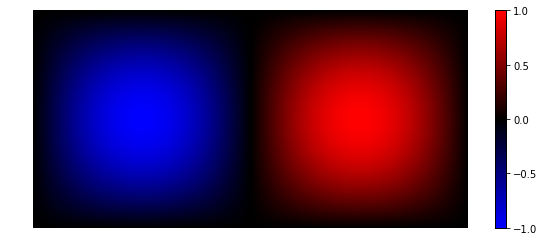

In [6]:
show(Z, norm, cmap)

Let's tweak the data range, so that zero is not at the centre.

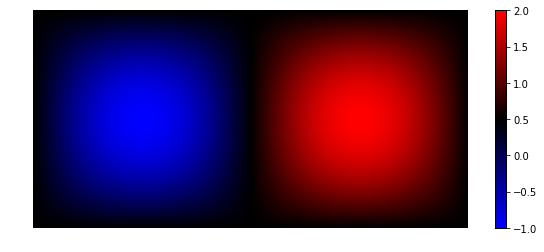

In [7]:
Z = -np.sin(X)*np.sin(Y)
Z = 3/2.*Z + 1/2.

norm = matplotlib.colors.Normalize(vmin=round(Z.min()),vmax=round(Z.max()))
show(Z, norm, cmap)

The image looks the same, which is misleading. We want the threshold value (Z=0) to be at the neutral point (black colour) of the colour map.

Using a pre-defined colour mapping, the only way to get this is by restricting the mapped data range so that it be symmetric (then part of the plot is saturated):

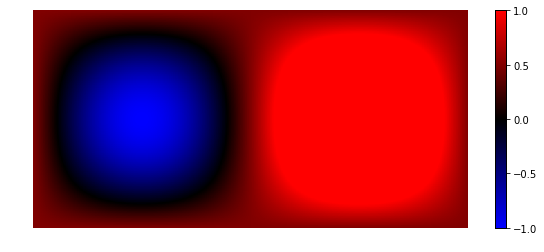

In [8]:
norm = matplotlib.colors.Normalize(vmin=-1,vmax=+1)
show(Z, norm, cmap)

To display the full range, the solution, of course, is to move the midpoint. <br>We simply have to do a linear interpolation by parts.<br>This can be done either in data space or in colour space.

## stretch in data space

We define a custom normalizer.<br>
https://matplotlib.org/tutorials/colors/colormapnorms.html

In [9]:
class MidpointNormalize(matplotlib.colors.Normalize):
    """a linear normalizer from [vmin,vmid,vmax] to [0,0.5,1]"""
    
    def __init__(self, vmin=None, vmax=None, vmid=None, clip=False):
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)
        self.range_data = [vmin, vmid, vmax]
        self.range_cmap = [   0,  0.5,    1]

    def __call__(self, value, clip=None):
        # ignoring masked values and clipping
        # linear interpolation from data range to colour range
        value = np.interp(value, self.range_data, self.range_cmap)
        return np.ma.masked_array(value)
    
    def inverse(self, value):
        # needs to be defined, used to put the ticks
        # linear interpolation from colour range to data range
        value = np.interp(value, self.range_cmap, self.range_data)
        return np.ma.masked_array(value)

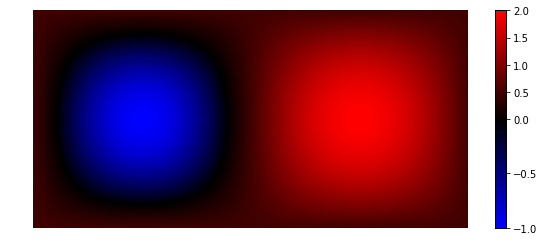

In [10]:
norm = MidpointNormalize(vmin=round(Z.min()),vmax=round(Z.max()),vmid=0)
show(Z, norm, cmap)

In this version the colour bar is symmetric, and regularly sampled data values make irregular ticks.

## stretch in colour space

We make our custom colour map interactive.<br>
https://matplotlib.org/tutorials/colors/colormap-manipulation.html

In [11]:
def cmap_div_mid(mid=0.5,n=1000):
    """generates a blue-black-red cmap with black at the given mid-point"""
    n_lower = int((mid-0)*n)
    n_upper = int((1-mid)*n)
    R = np.concatenate(( np.linspace(0,0,n_lower), np.linspace(0,1,n_upper) ))
    G = np.concatenate(( np.linspace(0,0,n_lower), np.linspace(0,0,n_upper) ))
    B = np.concatenate(( np.linspace(1,0,n_lower), np.linspace(0,0,n_upper) ))
    RGB = np.transpose(np.stack((R,G,B)))
    cmap = matplotlib.colors.ListedColormap(RGB,'red-blue-mid%.1f'%mid)
    return cmap

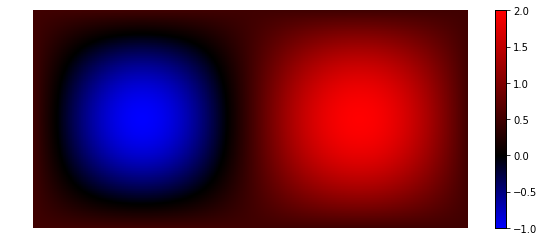

In [12]:
norm = matplotlib.colors.Normalize(vmin=round(Z.min()),vmax=round(Z.max()))
cmap = cmap_div_mid(mid=(0-Z.min())/(Z.max()-Z.min()))
show(Z, norm, cmap)

In this version the colour bar is stretched, and regularly sampled data values make regular ticks.